### Прогноз модели ARIMA/VAR


Документация по статистическим моделям:
https://www.statsmodels.org/stable/index.html

In [1]:
import numpy as np
import pandas as pd
from itertools import product

import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
sns.color_palette("pastel")

import warnings
warnings.filterwarnings("ignore")

## Data analysis

In [1]:
data = pd.read_csv("data/deposit.csv", sep=";")
data["Date"] = pd.to_datetime(data["Date"], format="%d.%m.%Y")
data.set_index("Date", inplace=True)
data["Deposit_rub"] = (
    data["Deposit_rub"].apply(lambda x: x.replace(",", ".")).astype(float)
)
data["Deposit_currency"] = (
    data["Deposit_currency"].apply(lambda x: x.replace(",", ".")).astype(float)
)

In [2]:
data.head()

,Deposit_rub,Deposit_currency,Inflation
Date,,,
2014-01-01,14000569.0,2956962.0,"0,34"
2014-02-01,13433121.0,3256299.0,"0,59"
2014-03-01,13510318.0,3397706.0,"0,99"
2014-04-01,13206977.0,3356873.0,"0,88"
2014-05-01,13507416.0,3340055.0,"0,94"


Text(0.5, 0, 'Months')

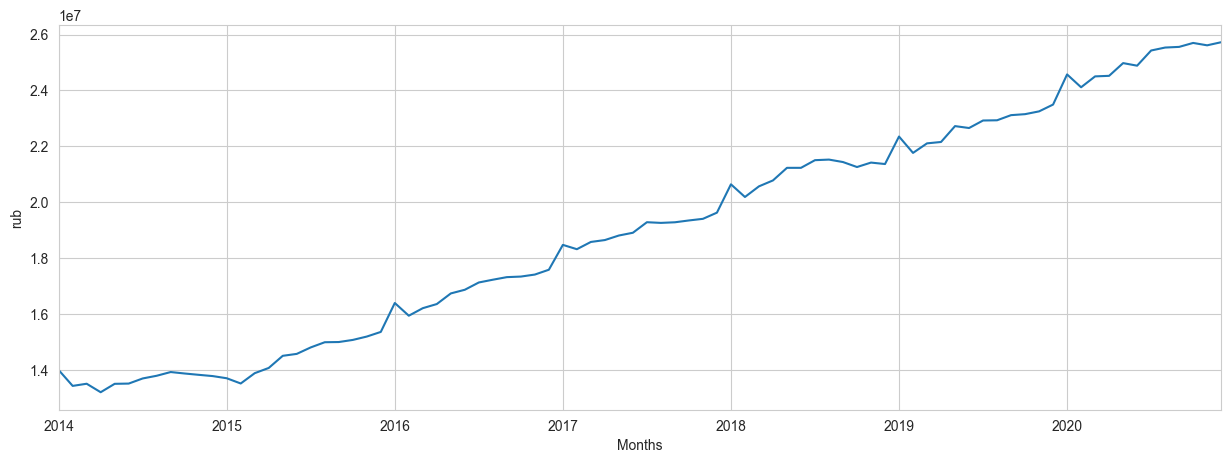

In [3]:
plt.figure(figsize=(15, 5))
data.Deposit_rub.plot()
plt.ylabel("rub")
plt.xlabel("Months")

In [4]:
# evaluate components of time-series
# evaluate Dickey-Fuller test for time-series stationarity
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.Deposit_rub)[1])

Dickey-Fuller test: p=0.914995


<Figure size 2000x500 with 0 Axes>

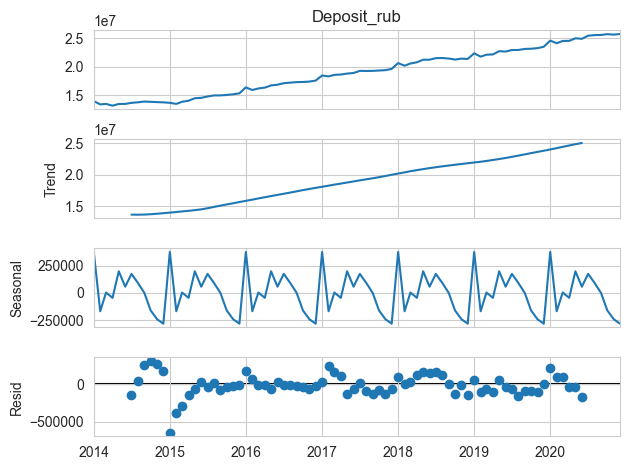

In [5]:
plt.figure(figsize=(20, 5))
sm.tsa.seasonal_decompose(data.Deposit_rub).plot()
plt.show()

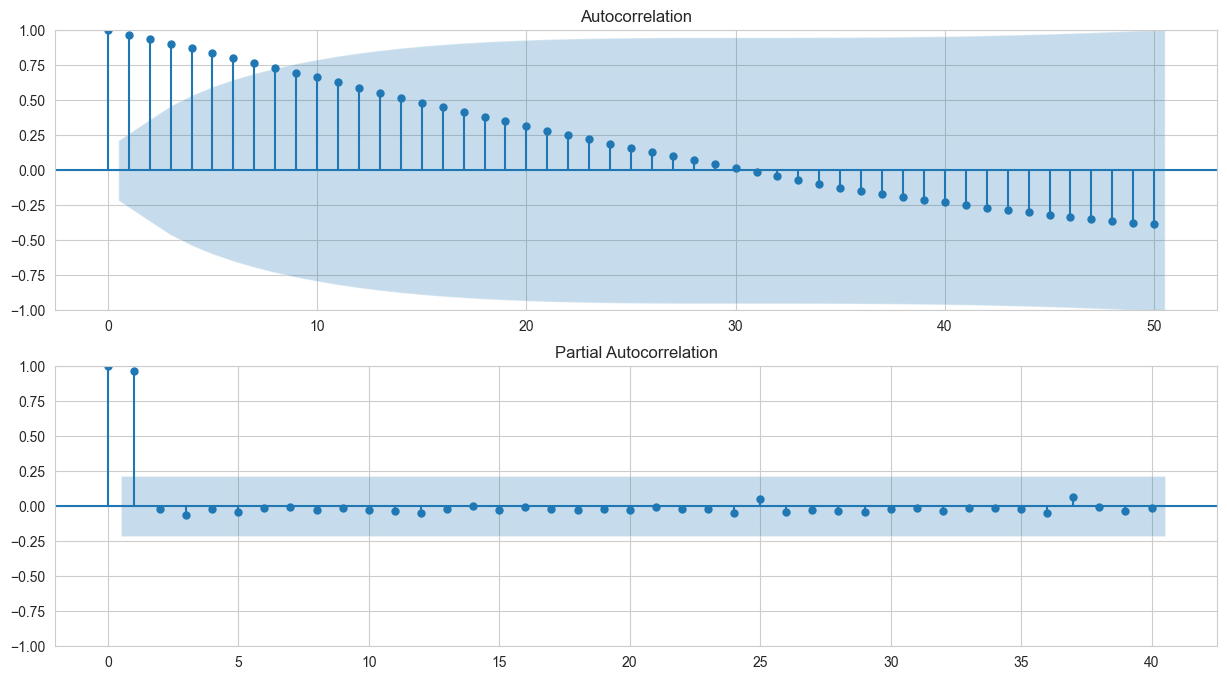

In [6]:
# let's calculate autocorrelation and partial autocorrelation components

plt.figure(figsize=(15, 8))

# autocorrelation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.Deposit_rub.values.squeeze(), lags=50, ax=ax)

# partial autocorrelation
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.Deposit_rub.values.squeeze(), lags=40, ax=ax)
plt.show()

Best Box-Cox parameter: 0.408736
Dickey-Fuller test: p=0.368960


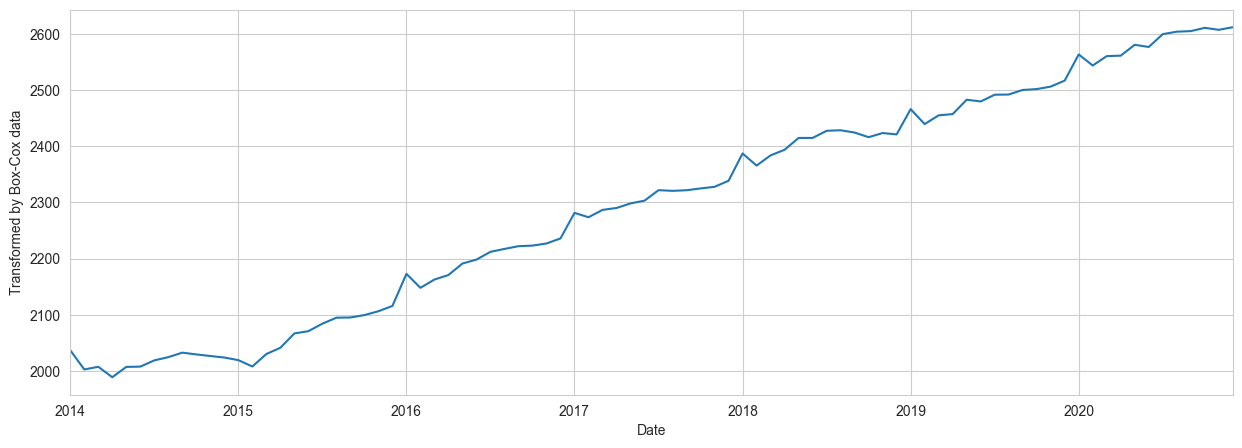

In [7]:
# Box-Cox transformation for dispersion stationarity

data["deposit_rub_box"], lmbda = stats.boxcox(data.Deposit_rub)
plt.figure(figsize=(15, 5))
data.deposit_rub_box.plot()
plt.ylabel("Transformed by Box-Cox data")
print("Best Box-Cox parameter: %f" % lmbda)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.deposit_rub_box)[1])

In [8]:
plt.rcParams["figure.figsize"] = (15, 10)

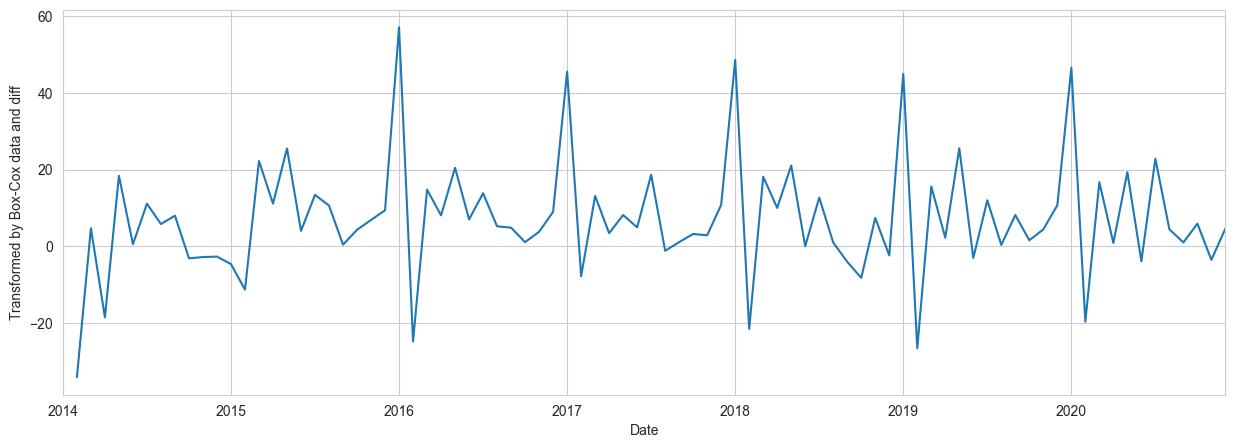

Dickey-Fuller test: p=0.004385


In [9]:
# difference for 1 months

data["deposit_rub_box_diff"] = data.deposit_rub_box - data.deposit_rub_box.shift(1)
plt.subplots(figsize=(15, 5))
data.deposit_rub_box_diff.plot()
plt.ylabel("Transformed by Box-Cox data and diff")
plt.show()
print(
    "Dickey-Fuller test: p=%f"
    % sm.tsa.stattools.adfuller(data.deposit_rub_box_diff[1:])[1]
)

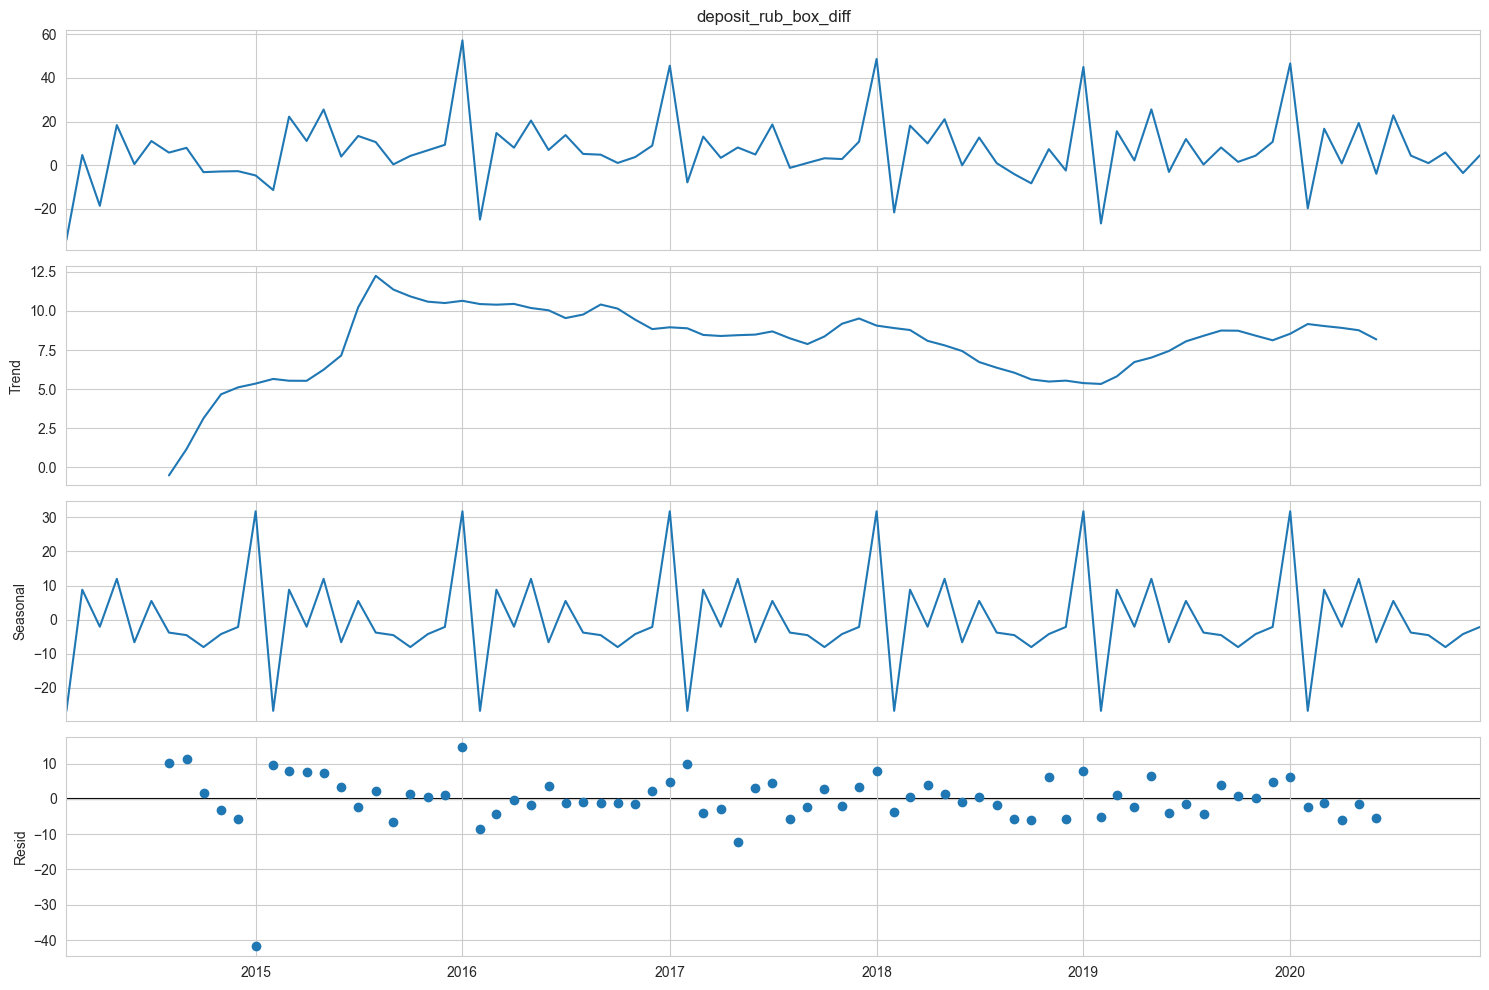

In [10]:
sm.tsa.seasonal_decompose(data.deposit_rub_box_diff[1:]).plot()
plt.show()

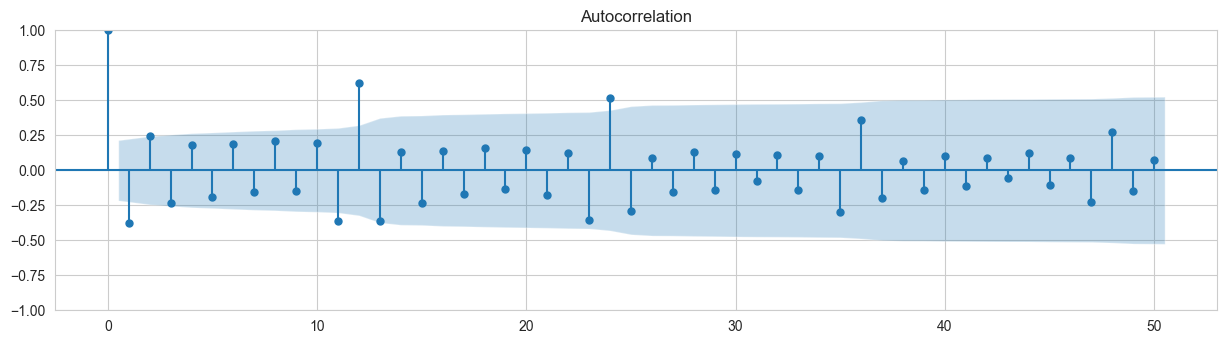

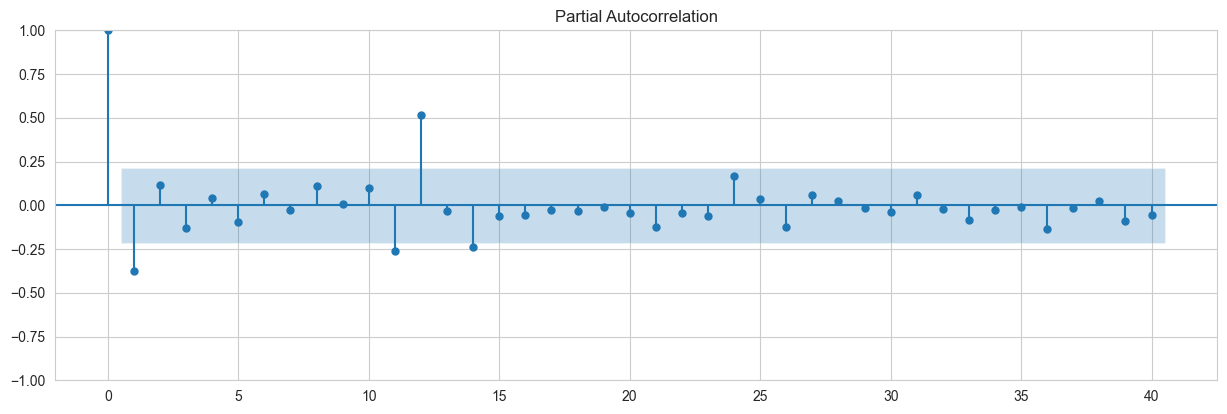

In [11]:
# let's calculate autocorrelation and partial autocorrelation components

plt.figure(figsize=(15, 8))

# autocorrelation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.deposit_rub_box_diff[1:].values.squeeze(), lags=50, ax=ax)
plt.show()

# partial autocorrelation
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(
    data.deposit_rub_box_diff[1:].values.squeeze(), lags=40, ax=ax
)
plt.show()

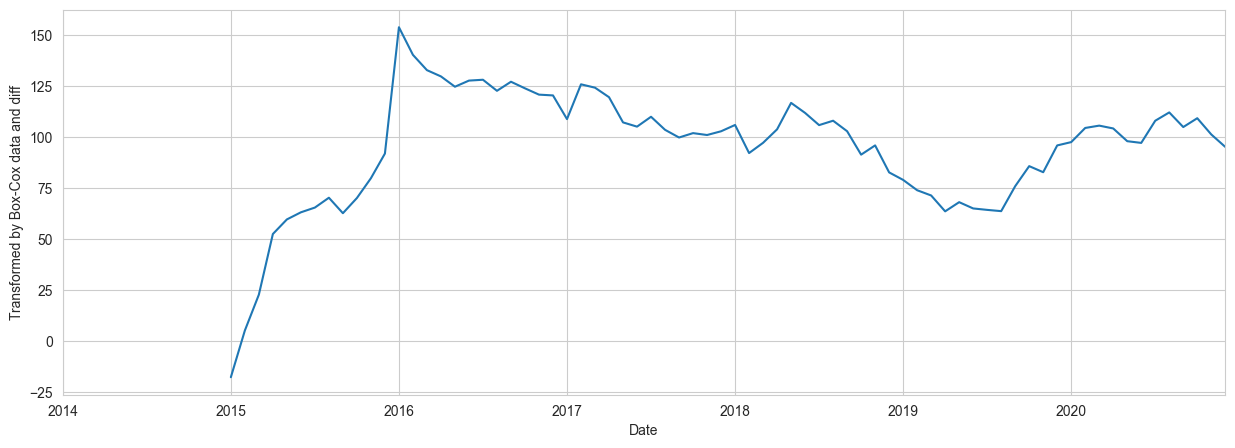

Dickey-Fuller test: p=0.000295


In [12]:
# CODE 1
# seasonal difference for 12 months

# Make additional 12-step difference by analogy with previous cell and evaluate Dickey-Fuller p-value
# Did the data become more stationary?

data["deposit_rub_box_diff_12"] = data.deposit_rub_box - data.deposit_rub_box.shift(12)
plt.subplots(figsize=(15, 5))
data.deposit_rub_box_diff_12.plot()
plt.ylabel("Transformed by Box-Cox data and diff")
plt.show()
print(
    "Dickey-Fuller test: p=%f"
    % sm.tsa.stattools.adfuller(data.deposit_rub_box_diff_12[12:])[1]
)

Вывод 1: Dickey-Fuller test: p=0.000295 => ряд стационарен, хотя визуально так не кажется

## (S)ARIMA model

In [17]:
from statsmodels.tsa.arima.model import ARIMA

In [18]:
model = ARIMA(data.deposit_rub_box, order=(2, 1, 2))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        deposit_rub_box   No. Observations:                   84
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -335.344
Date:                Wed, 09 Oct 2024   AIC                            680.688
Time:                        17:14:19   BIC                            692.782
Sample:                    01-01-2014   HQIC                           685.546
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0002      0.007      0.024      0.981      -0.014       0.015
ar.L2          0.9998      0.006    158.463      0.000       0.987       1.012
ma.L1         -0.0104      0.462     -0.022      0.982      -0.915       0.895
ma.L2         -0.9884      0.135     -7.330      0.000      -1.253      -0.724
sigma2       176.4877      0.003   6.01e+04      0.000     176.482     176.493
===================================================================================
Ljung-Box (L1) (Q):                   2.54   Jarque-Bera (JB):                11.62
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             0.52
Prob(H) (two-sided):                  0.47   Kurtosis:                         4.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.33e+20. Standard errors may be unstable.
"""

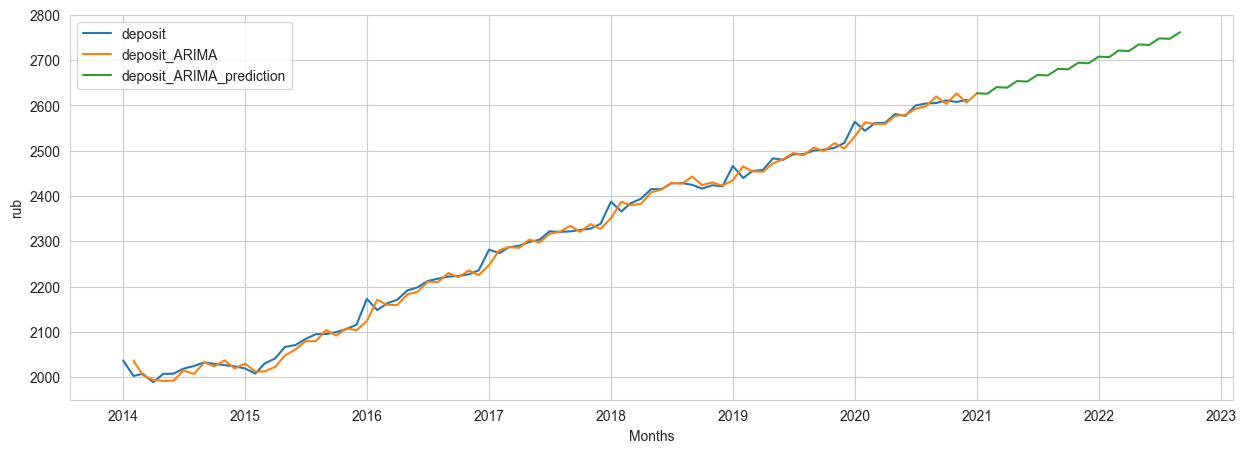

In [19]:
plt.figure(figsize=(15, 5))
plt.plot(data.deposit_rub_box, label="deposit")
plt.plot(res.predict(1, data.shape[0]), label="deposit_ARIMA")
plt.plot(
    res.predict(data.shape[0], data.shape[0] + 20), label="deposit_ARIMA_prediction"
)

plt.legend()
plt.ylabel("rub")
plt.xlabel("Months")
plt.show()

In [20]:
import statsmodels.api as sm

In [21]:
res_sarima = sm.tsa.statespace.SARIMAX(
            data.deposit_rub_box,
            order=(3, 1, 4),
            seasonal_order=(2, 1, 3, 12),
        ).fit(disp=-1)

In [22]:
res_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                            deposit_rub_box   No. Observations:                   84
Model:             SARIMAX(3, 1, 4)x(2, 1, [1, 2, 3], 12)   Log Likelihood                -255.462
Date:                                    Wed, 09 Oct 2024   AIC                            536.923
Time:                                            17:14:34   BIC                            566.338
Sample:                                        01-01-2014   HQIC                           548.621
                                             - 12-01-2020                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3400      0.483     -2.772      0.006      -2.288      -0.392
ar.L2         -1.1171      0.326     -3.432      0.001      -1.755      -0.479
ar.L3         -0.6503      0.326     -1.993      0.046      -1.290      -0.011
ma.L1          1.4760      0.509      2.898      0.004       0.478       2.474
ma.L2          1.6440      1.298      1.266      0.205      -0.900       4.188
ma.L3          1.2469      1.332      0.936      0.349      -1.364       3.857
ma.L4          0.2885      0.452      0.639      0.523      -0.597       1.174
ar.S.L12      -0.8280      5.959     -0.139      0.889     -12.508      10.852
ar.S.L24      -0.2944      1.970     -0.149      0.881      -4.156       3.567
ma.S.L12      -0.4585      8.523     -0.054      0.957     -17.164      16.247
ma.S.L24      -0.2607      4.664     -0.056      0.955      -9.402       8.881
ma.S.L36      -0.1889      1.674     -0.113      0.910      -3.470       3.092
sigma2        51.9926    161.855      0.321      0.748    -265.237     369.222
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):               126.74
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                             1.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
res_sarima.predict()

2014-01-01       0.000000
2014-02-01    2036.721198
2014-03-01    2002.526473
2014-04-01    2007.196609
2014-05-01    1988.615317
                 ...     
2020-08-01    2600.063078
2020-09-01    2608.772374
2020-10-01    2606.567049
2020-11-01    2613.980521
2020-12-01    2608.379312
Freq: MS, Name: predicted_mean, Length: 84, dtype: float64

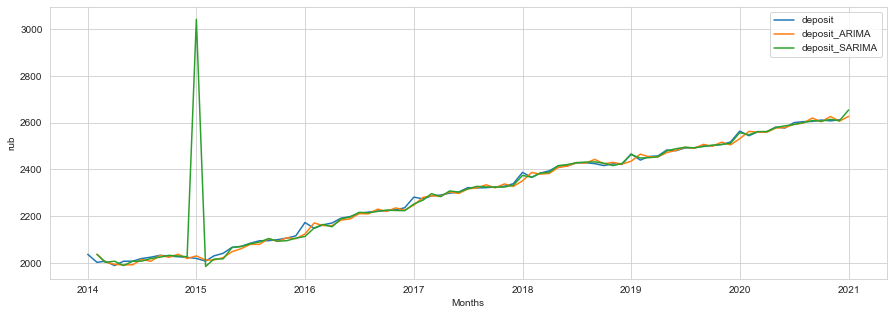

In [54]:
plt.figure(figsize=(15, 5))
plt.plot(data.deposit_rub_box, label="deposit")
plt.plot(res.predict(1, data.shape[0]), label="deposit_ARIMA")
plt.plot(res_sarima.predict(1, data.shape[0]), label="deposit_SARIMA")



plt.legend()
plt.ylabel("rub")
plt.xlabel("Months")
plt.show()

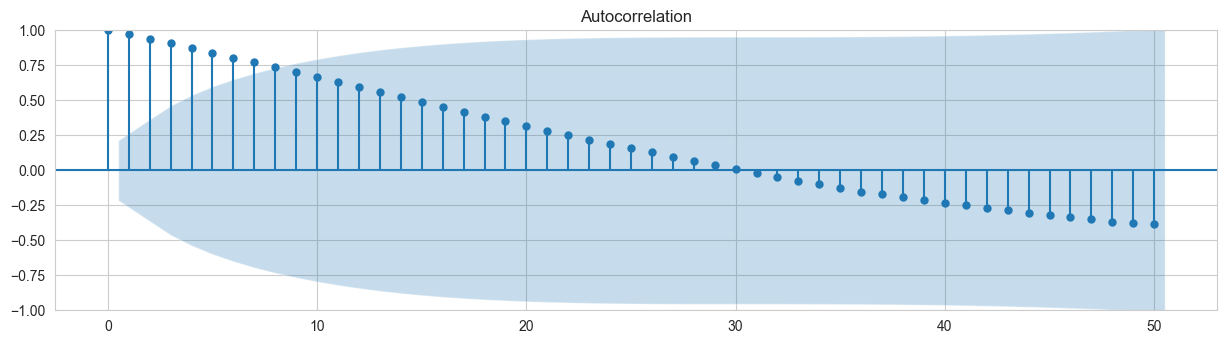

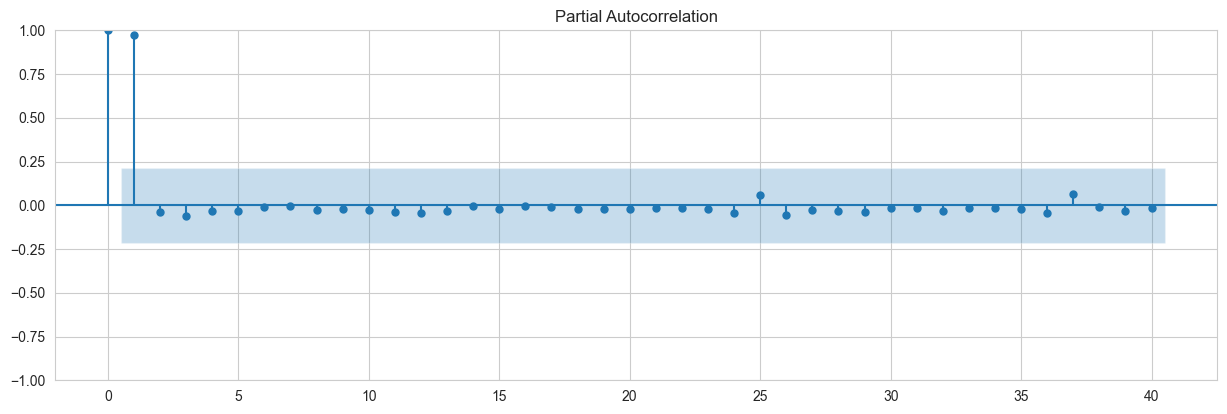

In [51]:
plt.figure(figsize=(15, 8))

# autocorrelation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.deposit_rub_box.values.squeeze(), lags=50, ax=ax)
plt.show()

# partial autocorrelation
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(
    data.deposit_rub_box.values.squeeze(), lags=40, ax=ax
)
plt.show()

In [91]:
# CODE 2
# Choose parameters for SARIMA model based on Autocorrelation and Partial Autocorrelation graphs

ps = range(0, 2)
d  = 1
qs = range(0, 2)
Ps = range(0, 2)
D  = 0
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print("Number of analysed models:", len(parameters_list))

Number of analysed models: 16


In [92]:
# here we will choose the best model
results = []
best_aic = float("inf")


for param in parameters_list:

    # try except for the case of wrong parameters
    try:
        model = sm.tsa.statespace.SARIMAX(
            data.Deposit_rub,
            order=(param[0], d, param[1]),
            seasonal_order=(param[2], D, param[3], 12),
        ).fit(disp=-1)

    # print wrong parameters and go on
    # AIC criteria:
    except ValueError:
        print("wrong parameters:", param)
        continue
    aic = model.aic

    # save best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])

In [93]:
# Top models
result_table = pd.DataFrame(results)
result_table.columns = ["parameters", "aic"]
print(result_table.sort_values(by="aic", ascending=True).head())

     parameters          aic
3  (1, 0, 1, 1)  2313.285468
2  (0, 1, 1, 1)  2314.579816
1  (0, 1, 0, 0)  2350.930977
0  (0, 0, 0, 0)  2352.578111


In [94]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          Deposit_rub   No. Observations:                   84
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1152.643
Date:                              Wed, 09 Oct 2024   AIC                           2313.285
Time:                                      17:50:37   BIC                           2322.961
Sample:                                  01-01-2014   HQIC                          2317.172
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0370      0.129     -0.286      0.775      -0.290       0.216
ar.S.L12       0.99

In [95]:
# inverse Box-Cox transformation:


def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda)


data["model"] = invboxcox(best_model.fittedvalues, lmbda)

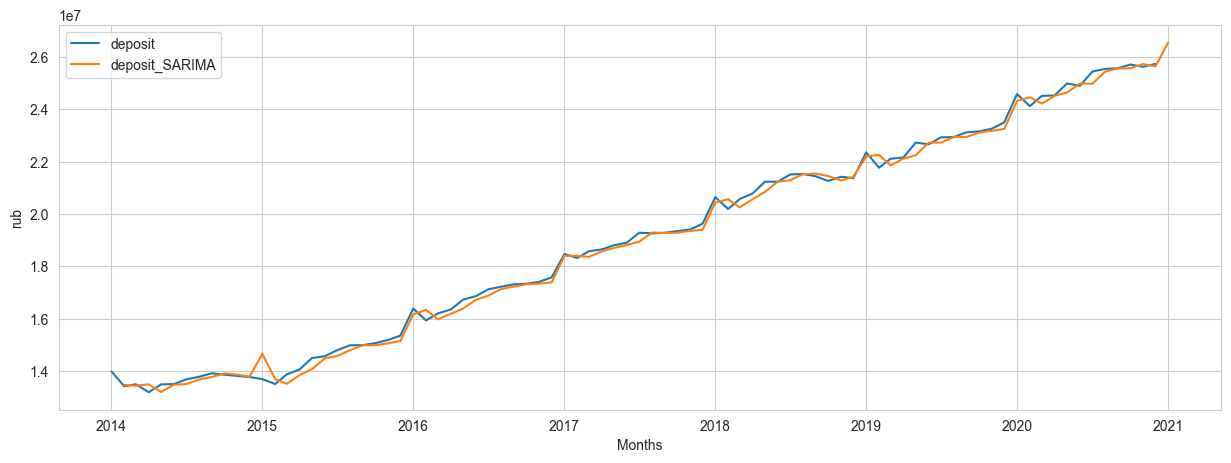

In [97]:
# CODE 3
# Plot the best model and original time series on the same figure

plt.figure(figsize=(15, 5))
plt.plot(data.Deposit_rub, label="deposit")
plt.plot(best_model.predict(1, data.shape[0]), label="deposit_SARIMA")

plt.legend()
plt.ylabel("rub")
plt.xlabel("Months")
plt.show()

In [59]:
# CODE 4
# Evaluate any metric to check  best model's performance

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

predictions = best_model.predict(start=1, end=data.shape[0])

# Расчет RMSE
rmse = np.sqrt(mean_squared_error(data.deposit_rub_box, predictions))
print(f"RMSE={rmse:.2f}")

# Расчет MAPE
mape = mean_absolute_percentage_error(data.deposit_rub_box, predictions) * 100
print(f"MAPE={mape:.2f}")

# Расчет R²
r2 = r2_score(data.deposit_rub_box, predictions)
print(f"R²={r2:.2f}")

RMSE=12.11
MAPE=0.34
R²=1.00


## Additional Time Series

level of inflation

In [60]:
data["Inflation"] = data["Inflation"].apply(lambda x: x.replace(",", ".")).astype(float)

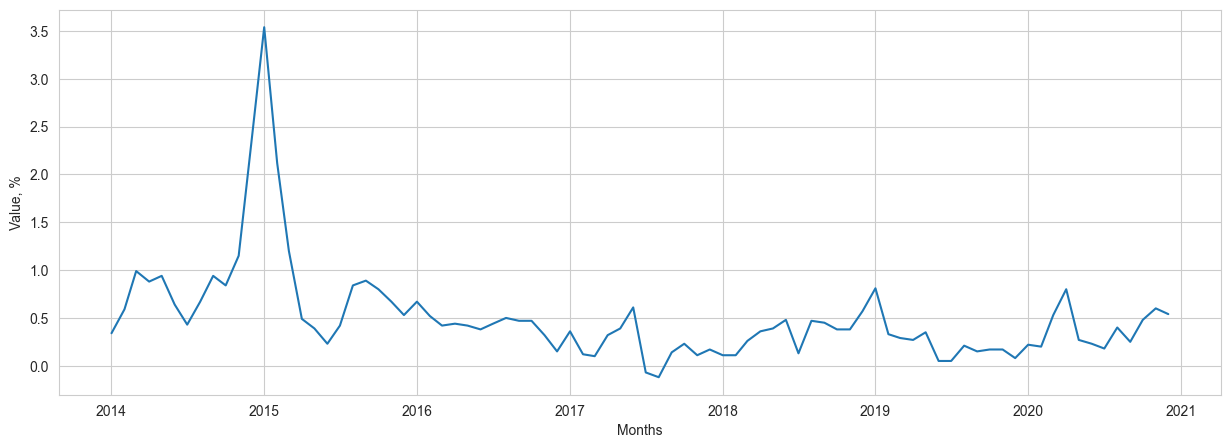

In [61]:
plt.figure(figsize=(15,5))
plt.plot(data.Inflation)
plt.ylabel("Value, %")
plt.xlabel("Months")
plt.show()

In [ ]:
# data.head()

usd rate

In [65]:
usd = pd.read_csv("data/usdrub.csv", sep=";")
usd["Date"] = pd.to_datetime(usd["Date"], format="%d.%m.%Y")
usd["USDRUB"] = usd["USDRUB"].apply(lambda x: x.replace(",", ".")).astype(float)

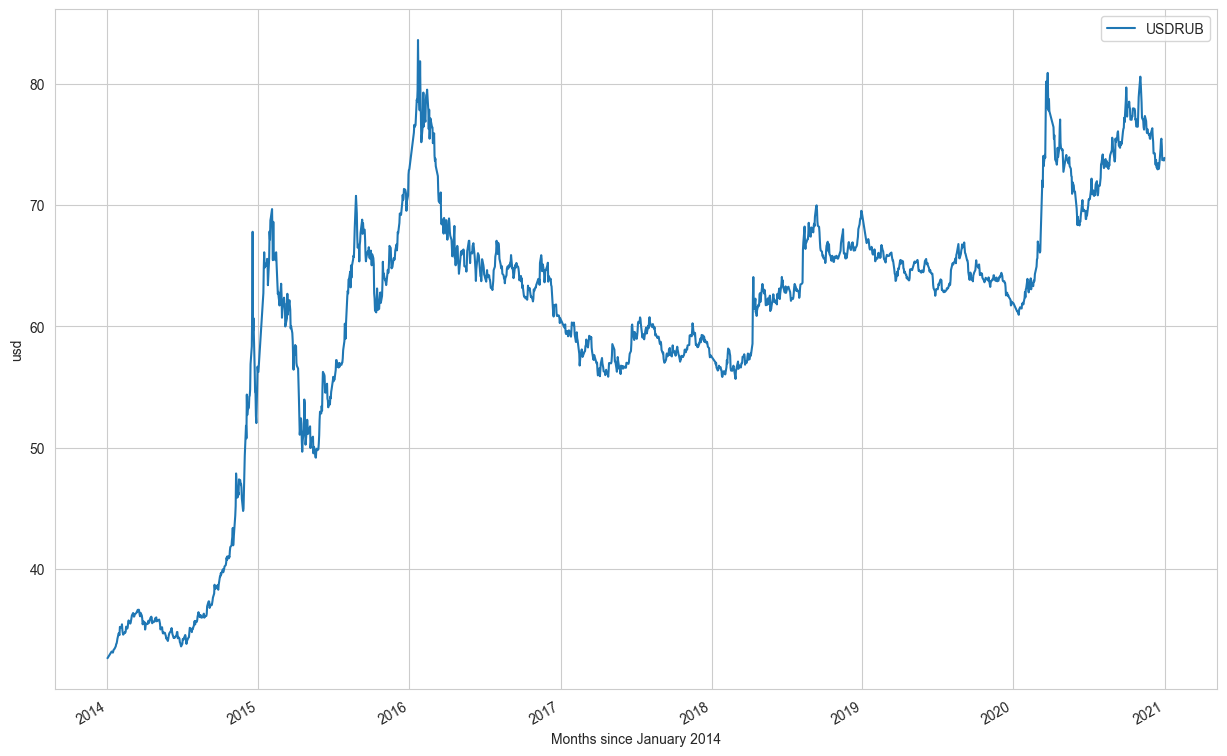

In [66]:
usd.set_index("Date").plot()
plt.ylabel("usd")
plt.xlabel("Months since January 2014")
plt.show()

In [67]:
import datetime

In [68]:
usd["Month"] = usd["Date"].apply(lambda x: datetime.datetime(x.year, x.month, 1))
usd = usd.groupby("Month")["USDRUB"].mean().to_frame()

<Figure size 1500x500 with 0 Axes>

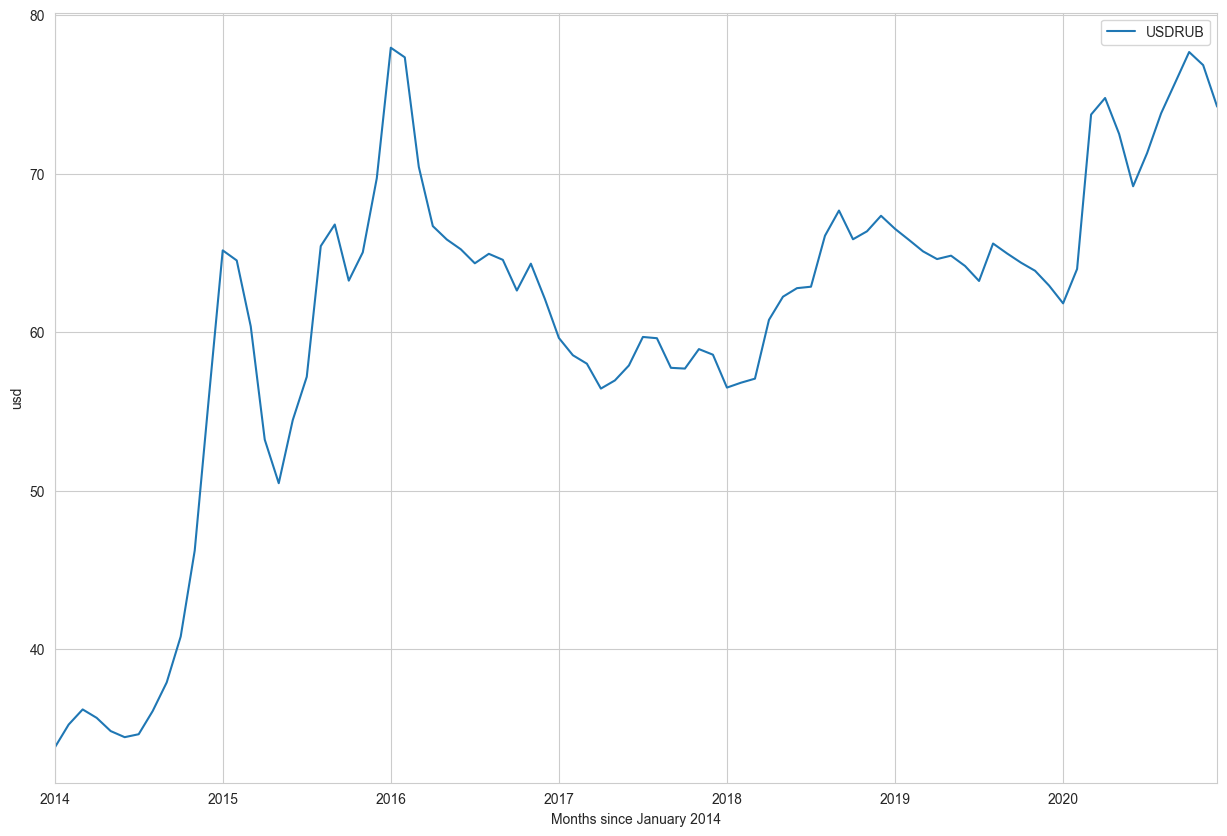

In [69]:
plt.figure(figsize=(15,5))
usd.plot()
plt.ylabel("usd")
plt.xlabel("Months since January 2014")
plt.show()

In [71]:
# https://rosstat.gov.ru/labor_market_employment_salaries
data_wage = pd.read_csv("data/Wage.csv", sep=";")
data_wage["date"] = pd.to_datetime(data_wage["date"], format="%d.%m.%Y")
data_wage.set_index("date", inplace=True)

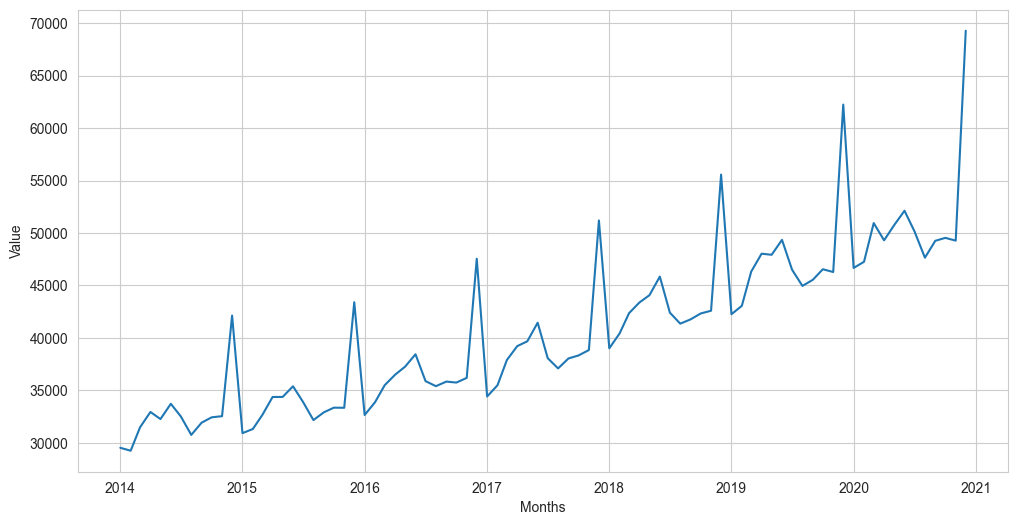

In [72]:
plt.figure(figsize=(12, 6))
plt.plot(data_wage.wage)
plt.ylabel("Value")
plt.xlabel("Months")
plt.show()

In [73]:
def CrossCorr(datax, datay, maxlag=12):
    corr = dict()
    dy = pd.Series(datay)
    for i in range(1, maxlag):
        c = abs(datax.corr(dy.shift(i), method="spearman"))
        corr[i] = c
    return corr

In [74]:
CrossCorr(data.Deposit_rub, usd.USDRUB)

{1: 0.5735275597162167,
 2: 0.5649372557982608,
 3: 0.5507678410117435,
 4: 0.5425222691045476,
 5: 0.5295034079844206,
 6: 0.5075304442393049,
 7: 0.4973973395026026,
 8: 0.48429254955570744,
 9: 0.46881934566145084,
 10: 0.4503961495742317,
 11: 0.45896581513019874}

In [75]:
CrossCorr(data.Deposit_rub, data.Inflation)

{1: 0.5484949621388631,
 2: 0.5803645944103593,
 3: 0.6008651723693677,
 4: 0.5965837998356807,
 5: 0.6074094112489161,
 6: 0.6098307786798793,
 7: 0.6031831797128332,
 8: 0.6035881020327934,
 9: 0.6406237994326204,
 10: 0.6731894709509715,
 11: 0.6683949274886994}

In [76]:
CrossCorr(data.Deposit_rub, data_wage.wage)

{1: 0.9150959237647454,
 2: 0.9020907478151087,
 3: 0.9068879855465221,
 4: 0.905672761368964,
 5: 0.9052823758519962,
 6: 0.9007827615422552,
 7: 0.9042536410957464,
 8: 0.8962132604237867,
 9: 0.8922332859174964,
 10: 0.88584968530174,
 11: 0.8840861409354561}

In [77]:
import statsmodels.api as sm

In [78]:
# GrangerTest
x = pd.DataFrame()
x["res"] = data.Deposit_rub
x["cause"] = usd.USDRUB
gr_test = sm.tsa.stattools.grangercausalitytests(x, maxlag=12, verbose=False)
p1=min([gr_test[j][0]['ssr_ftest'][1] for j in gr_test])
print(p1)
# gr_test

0.0004008591454636105


## VAR model

In [79]:
from statsmodels.tsa.api import VAR

In [80]:
data_var = pd.concat(
    [data.Deposit_rub, data.Inflation, usd.USDRUB, data_wage.wage], axis=1
)

In [81]:
data_var

,Deposit_rub,Inflation,USDRUB,wage
2014-01-01,14000569.00,0.34,33.784118,29535
2014-02-01,13433121.00,0.59,35.244500,29255
2014-03-01,13510318.00,0.99,36.199000,31486
2014-04-01,13206977.00,0.88,35.667727,32947
2014-05-01,13507416.00,0.94,34.834500,32272
...,...,...,...,...
2020-08-01,25534027.52,0.40,73.799524,47649
2020-09-01,25557608.90,0.25,75.726818,49259
2020-10-01,25699001.52,0.48,77.663478,49539
2020-11-01,25613765.36,0.60,76.838947,49274


In [82]:
for i in [1, 2, 3, 4, 5]:
    model = VAR(data_var)
    results = model.fit(i)
    print("Order =", i)
    print("AIC: ", results.aic)
#     print("BIC: ", results.bic)
    print()

Order = 1
AIC:  40.570439008970766

Order = 2
AIC:  39.58728882408882

Order = 3
AIC:  39.68069016229838

Order = 4
AIC:  39.684594585895965

Order = 5
AIC:  39.62809212844385



In [83]:
results = model.fit(5)
# results.summary()

In [84]:
# results.plot()

In [85]:
results.forecast(data_var.values, 5)

array([[ 2.69865214e+07,  6.47464585e-01,  7.44379273e+01,
         5.05560929e+04],
       [ 2.65776116e+07,  1.27379203e-02,  7.51679608e+01,
         5.21799571e+04],
       [ 2.71185165e+07,  2.03610691e-02,  7.62802156e+01,
         5.27204454e+04],
       [ 2.70288345e+07,  3.68121705e-02,  7.45240319e+01,
         4.90252891e+04],
       [ 2.72516749e+07, -3.61696755e-02,  7.39167498e+01,
         5.38459396e+04]])

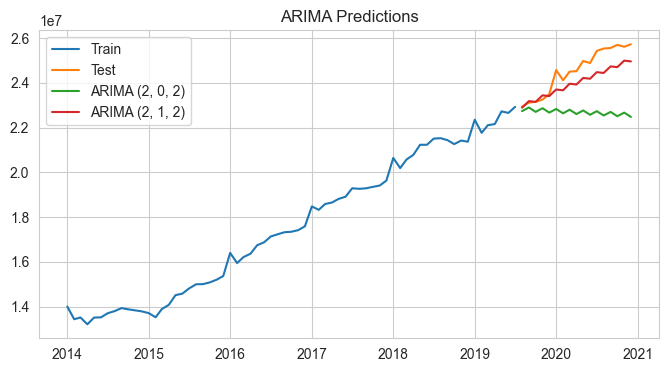

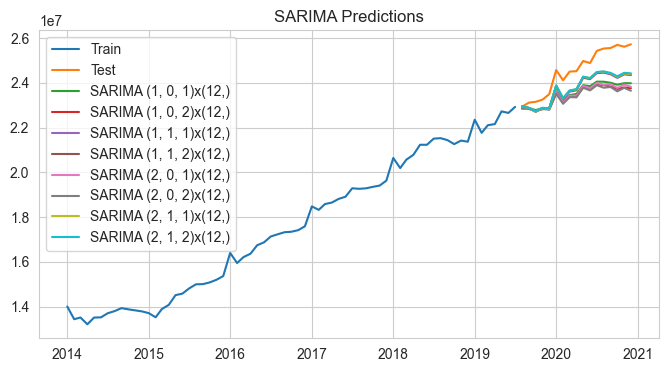

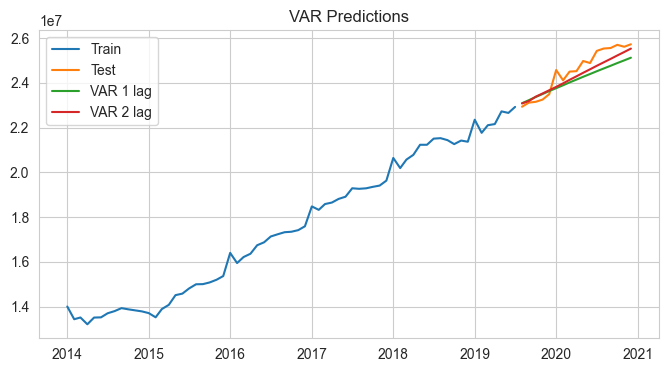

,Model,Order,Seasonal_Order,RMSE,MAPE
11,VAR,2,None,3.981070e+05,1.388950
10,VAR,1,None,5.754230e+05,2.018910
1,ARIMA,"(2, 1, 2)",None,6.623208e+05,2.239669
9,SARIMA,"(2, 1, 2)","(12,)",8.536033e+05,3.099502
8,SARIMA,"(2, 1, 1)","(12,)",8.684352e+05,3.152983
5,SARIMA,"(1, 1, 2)","(12,)",8.821478e+05,3.201526
4,SARIMA,"(1, 1, 1)","(12,)",9.029990e+05,3.275383
2,SARIMA,"(1, 0, 1)","(12,)",1.143759e+06,4.053464
6,SARIMA,"(2, 0, 1)","(12,)",1.217226e+06,4.321692
3,SARIMA,"(1, 0, 2)","(12,)",1.261256e+06,4.469281


In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from itertools import product

# Загрузка данных
train_size = int(len(data_var) * 0.8)
train, test = data_var[:train_size], data_var[train_size:]

# Функция для расчета метрик
def calculate_metrics(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = mean_absolute_percentage_error(true, pred) * 100
    return rmse, mape

# Словарь для хранения результатов
results = []

# Перебор гиперпараметров для ARIMA и построение графиков
arima_params = list(product([2], [0, 1], [2]))  # Пример: различные значения p, d, q
plt.figure(figsize=(8, 4))
plt.plot(train['Deposit_rub'], label='Train')
plt.plot(test['Deposit_rub'], label='Test')
for order in arima_params:
    arima_model = ARIMA(train['Deposit_rub'], order=order).fit()
    arima_pred = arima_model.forecast(steps=len(test))
    arima_rmse, arima_mape = calculate_metrics(test['Deposit_rub'], arima_pred)
    results.append(('ARIMA', order, None, arima_rmse, arima_mape))
    plt.plot(test.index, arima_pred, label=f'ARIMA {order}')
plt.legend(loc='best')
plt.title('ARIMA Predictions')
plt.savefig('arima_predictions.jpg')
plt.show()

# Перебор гиперпараметров для SARIMA и построение графиков
sarima_params = list(product([1, 2], [0, 1], [1, 2], [12]))  # Пример: p, d, q, сезонность
plt.figure(figsize=(8, 4))
plt.plot(train['Deposit_rub'], label='Train')
plt.plot(test['Deposit_rub'], label='Test')
for order in sarima_params:
    sarima_model = SARIMAX(train['Deposit_rub'], order=order[:3], seasonal_order=(order[0], order[1], order[2], order[3])).fit()
    sarima_pred = sarima_model.forecast(steps=len(test))
    sarima_rmse, sarima_mape = calculate_metrics(test['Deposit_rub'], sarima_pred)
    results.append(('SARIMA', order[:3], order[3:], sarima_rmse, sarima_mape))
    plt.plot(test.index, sarima_pred, label=f'SARIMA {order[:3]}x{order[3:]}')
plt.legend(loc='best')
plt.title('SARIMA Predictions')
plt.savefig('sarima_predictions.jpg')
plt.show()

# Перебор лагов для VAR и построение графиков
plt.figure(figsize=(8, 4))
plt.plot(train['Deposit_rub'], label='Train')
plt.plot(test['Deposit_rub'], label='Test')
for lag in [1, 2]:
    var_model = VAR(train[['Deposit_rub', 'Inflation', 'USDRUB', 'wage']])
    var_fitted = var_model.fit(lag)
    var_pred = var_fitted.forecast(train[['Deposit_rub', 'Inflation', 'USDRUB', 'wage']].values[-var_fitted.k_ar:], steps=len(test))
    var_pred_df = pd.DataFrame(var_pred, index=test.index, columns=['Deposit_rub', 'Inflation', 'USDRUB', 'wage'])
    var_rmse, var_mape = calculate_metrics(test['Deposit_rub'], var_pred_df['Deposit_rub'])
    results.append(('VAR', lag, None, var_rmse, var_mape))
    plt.plot(test.index, var_pred_df['Deposit_rub'], label=f'VAR {lag} lag')
plt.legend(loc='best')
plt.title('VAR Predictions')
plt.savefig('var_predictions.jpg')
plt.show()

# Создание таблицы с результатами
results_df = pd.DataFrame(results, columns=['Model', 'Order', 'Seasonal_Order', 'RMSE', 'MAPE'])
results_df.sort_values(['RMSE','MAPE'])
# print(results_df)


In [ ]:
# CODE 6

# Choose any addition financial time series.
# Calculate crosscorrelatioin/grangercausalitytests
# Add this time series to the model.
# Compare forecast quality.

In [137]:
url = "https://cbr.ru/hd_base/KeyRate/?UniDbQuery.Posted=True&UniDbQuery.From=01.01.2014&UniDbQuery.To=31.12.2020"
keyrate = pd.read_html(url)[0][::-1].reset_index(drop=True)
keyrate

,Дата,Ставка
0,09.01.2014,550
1,10.01.2014,550
2,13.01.2014,550
3,14.01.2014,550
4,15.01.2014,550
...,...,...
1730,25.12.2020,425
1731,28.12.2020,425
1732,29.12.2020,425
1733,30.12.2020,425


In [144]:
keyrate['Дата'] = pd.to_datetime(keyrate['Дата'], format='%d.%m.%Y')
keyrate['Месяц'] = keyrate['Дата'].dt.to_period('M')
monthly_median = keyrate.groupby('Месяц')['Ставка'].median().reset_index()
monthly_median['Ставка'] = monthly_median['Ставка'] / 100
monthly_median['Дата'] = monthly_median['Месяц'].dt.to_timestamp()
monthly_median = monthly_median[['Дата', 'Ставка']]
monthly_median


,Дата,Ставка
0,2014-01-01,5.50
1,2014-02-01,5.50
2,2014-03-01,7.00
3,2014-04-01,7.00
4,2014-05-01,7.50
...,...,...
79,2020-08-01,4.25
80,2020-09-01,4.25
81,2020-10-01,4.25
82,2020-11-01,4.25


In [148]:
data_var

,Deposit_rub,Inflation,USDRUB,wage
2014-01-01,14000569.00,0.34,33.784118,29535
2014-02-01,13433121.00,0.59,35.244500,29255
2014-03-01,13510318.00,0.99,36.199000,31486
2014-04-01,13206977.00,0.88,35.667727,32947
2014-05-01,13507416.00,0.94,34.834500,32272
...,...,...,...,...
2020-08-01,25534027.52,0.40,73.799524,47649
2020-09-01,25557608.90,0.25,75.726818,49259
2020-10-01,25699001.52,0.48,77.663478,49539
2020-11-01,25613765.36,0.60,76.838947,49274


In [161]:
final_df = data_var.merge(monthly_median, left_index=True, right_on='Дата')
final_df.set_index(final_df['Дата'], inplace=True)
final_df

,Deposit_rub,Inflation,USDRUB,wage,Дата,Ставка
Дата,,,,,,
2014-01-01,14000569.00,0.34,33.784118,29535,2014-01-01,5.50
2014-02-01,13433121.00,0.59,35.244500,29255,2014-02-01,5.50
2014-03-01,13510318.00,0.99,36.199000,31486,2014-03-01,7.00
2014-04-01,13206977.00,0.88,35.667727,32947,2014-04-01,7.00
2014-05-01,13507416.00,0.94,34.834500,32272,2014-05-01,7.50
...,...,...,...,...,...,...
2020-08-01,25534027.52,0.40,73.799524,47649,2020-08-01,4.25
2020-09-01,25557608.90,0.25,75.726818,49259,2020-09-01,4.25
2020-10-01,25699001.52,0.48,77.663478,49539,2020-10-01,4.25


In [163]:
CrossCorr(final_df.Deposit_rub, final_df['Ставка'])

{1: 0.6292986365896949,
 2: 0.6142743720012107,
 3: 0.5945147838856714,
 4: 0.5767622498099391,
 5: 0.5612369555157197,
 6: 0.5423237245220988,
 7: 0.5235693840966655,
 8: 0.5042031734320878,
 9: 0.487317259811125,
 10: 0.4682479165767527,
 11: 0.4519818187485479}

In [183]:
from statsmodels.tsa.stattools import grangercausalitytests


# 2. Гранжеровский тест на причинность
max_lag = 5  # максимальное количество лагов для тестирования
granger_test = grangercausalitytests(final_df[['Deposit_rub', 'Ставка']], max_lag)
for i in range(len(granger_test)):
    print(f'lag = {i+1}, p = {granger_test[i+1][0]["params_ftest"][1]:.2}')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0096  , p=0.3180  , df_denom=80, df_num=1
ssr based chi2 test:   chi2=1.0475  , p=0.3061  , df=1
likelihood ratio test: chi2=1.0409  , p=0.3076  , df=1
parameter F test:         F=1.0096  , p=0.3180  , df_denom=80, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0623  , p=0.1341  , df_denom=77, df_num=2
ssr based chi2 test:   chi2=4.3924  , p=0.1112  , df=2
likelihood ratio test: chi2=4.2788  , p=0.1177  , df=2
parameter F test:         F=2.0623  , p=0.1341  , df_denom=77, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7392  , p=0.0493  , df_denom=74, df_num=3
ssr based chi2 test:   chi2=8.9949  , p=0.0294  , df=3
likelihood ratio test: chi2=8.5296  , p=0.0362  , df=3
parameter F test:         F=2.7392  , p=0.0493  , df_denom=74, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8059  , p=0.0319  , df_d

Вывод: Основываясь на результатах тестов, можно утверждать, что влияние переменной "Ставка" на переменную "Deposit_rub" значимо проявляется с задержкой в 3-4 периода.

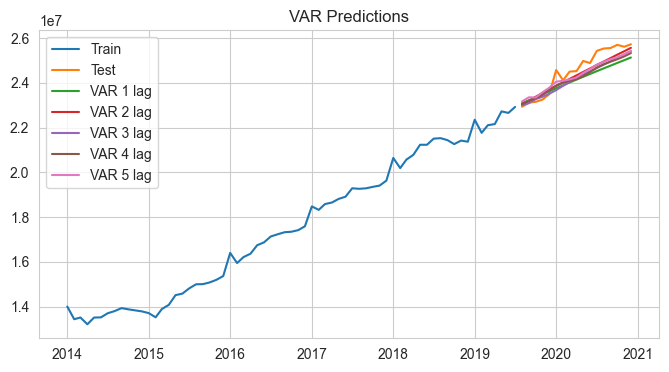

,Model,Order,RMSE,MAPE
1,VAR,2,372158.235677,1.290144
4,VAR,5,395457.111209,1.461954
3,VAR,4,466905.360366,1.627536
2,VAR,3,467446.716611,1.539032
0,VAR,1,572790.276145,2.006196


In [186]:
# Загрузка данных
train_size = int(len(final_df) * 0.8)
train, test = final_df[:train_size], final_df[train_size:]

# Функция для расчета метрик
def calculate_metrics(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = mean_absolute_percentage_error(true, pred) * 100
    return rmse, mape

# Словарь для хранения результатов
results = []

# Перебор лагов для VAR и построение графиков
plt.figure(figsize=(8, 4))
plt.plot(train['Deposit_rub'], label='Train')
plt.plot(test['Deposit_rub'], label='Test')
for lag in [1, 2, 3, 4, 5]:
    var_model = VAR(train[['Deposit_rub', 'Inflation', 'USDRUB', 'wage', 'Ставка']])
    var_fitted = var_model.fit(lag)
    var_pred = var_fitted.forecast(train[['Deposit_rub', 'Inflation', 'USDRUB', 'wage', 'Ставка']].values[-var_fitted.k_ar:], steps=len(test))
    var_pred_df = pd.DataFrame(var_pred, index=test.index, columns=['Deposit_rub', 'Inflation', 'USDRUB', 'wage', 'Ставка'])
    var_rmse, var_mape = calculate_metrics(test['Deposit_rub'], var_pred_df['Deposit_rub'])
    results.append(('VAR', lag, var_rmse, var_mape))
    plt.plot(test.index, var_pred_df['Deposit_rub'], label=f'VAR {lag} lag')
plt.legend(loc='best')
plt.title('VAR Predictions')
plt.savefig('var_predictions.jpg')
plt.show()

# Создание таблицы с результатами
results_df = pd.DataFrame(results, columns=['Model', 'Order', 'RMSE', 'MAPE'])
results_df.sort_values(['RMSE','MAPE'])
# print(results_df)

Итог: пусть и не значительно, то информация о ставке ЦБ умешьньшила значения RMSE и MAPE по сравнению с прошлыми моделями VAR.